In [2]:
import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram

from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum
from apnet.datasets import MedleySolosDb

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
dataset_name = 'MedleySolosDb'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'test'

In [4]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models'][model_name]

In [5]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = MedleySolosDb(dataset_path)
dataset.check_if_downloaded()

True

In [6]:
features = MelSpectrogram(**params_features)
print(features.get_shape())
if not features.check_if_extracted(dataset):
    features.extract(dataset)

(1, 128, 256)


In [7]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    },
    metrics=['classification'],
    **params['models'][model_name]['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

(40, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 256)     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 32, 64, 48), 116544      input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 32, 64, 48)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 40, 64)       3932160     features[0][0]                   
__________________________________________________________________________________________________
s

In [8]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

data_gen.audio_file_list = data_gen.audio_file_list[:int(len( data_gen.audio_file_list)/3)]


In [9]:
X, Y = data_gen.get_data()

In [10]:
print(X.shape)

(1947, 128, 256)


In [11]:
#exp_folder = os.path.join(exp_path, model_name, dataset_name, fold_name)
#prototypes = load_pickle(os.path.join(exp_folder, 'prototypes.pickle'))
model_container.get_prototypes(X)
#prototypes = model_container.prototypes
model_container.prototypes.sort()

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!


In [14]:
prototypes = model_container.prototypes

In [15]:
print(prototypes.embeddings.shape)

prototypes_distances = np.sum((np.expand_dims(prototypes.embeddings,0) - np.expand_dims(prototypes.embeddings,1))**2, axis=(2,3,4))

print(prototypes_distances.shape)

(40, 32, 64, 48)
(40, 40)


In [18]:
print(prototypes.classes)
print(dataset.label_list)

[0 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 6 6 7 7 7 7 7 7 7 7
 7 7 7]
['clarinet', 'distorted electric guitar', 'female singer', 'flute', 'piano', 'tenor saxophone', 'trumpet', 'violin']


(40, 40)
[ 0.  2.  6. 12. 15. 26. 28. 39.]
[1.  2.  3.  1.5 5.5 1.  5.5]


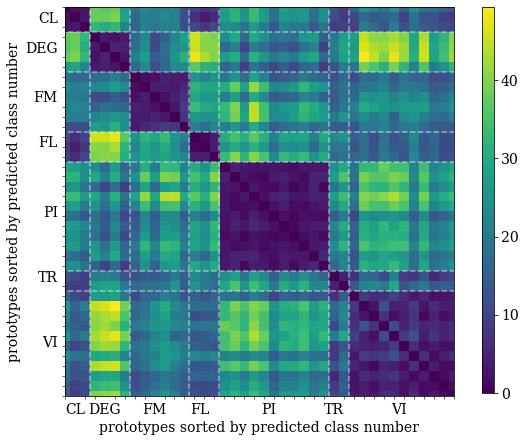

In [19]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

class_names = dataset.label_list
class_names_av = ['CL', 'DEG', 'FM', 'FL', 'PI', 'TR', 'VI']
n_classes = len(dataset.label_list)

classes_sort = prototypes.classes
prototypes_distances_sort = prototypes_distances

#prototypes_distances_sort = np.mean(prototypes_distances_sort,axis=2)

print(prototypes_distances_sort.shape)
class_sort_diff = np.diff(classes_sort)
class_sort_diff = np.concatenate((class_sort_diff,np.ones(1,)*n_classes),axis=0)
class_sort_diff_ixs = np.where(class_sort_diff)[0]
class_sort_diff_ixs = np.concatenate((np.zeros(1,),class_sort_diff_ixs),axis=0)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(prototypes_distances_sort)
ax.set_xlabel('prototypes sorted by predicted class number')
ax.set_ylabel('prototypes sorted by predicted class number')
ax.set_xticks(range(len(classes_sort)),minor=True)
ax.set_xticklabels([])
#print(class_sort_diff_ixs[:n_classes] + np.diff(class_sort_diff_ixs)/2.)
print(class_sort_diff_ixs[:n_classes] )
print(np.diff(class_sort_diff_ixs)/2)
ax.set_xticks(class_sort_diff_ixs[:n_classes-1] + np.diff(class_sort_diff_ixs)/2., minor=False)
ax.set_xticklabels(class_names_av,minor=False)
ax.set_yticks(range(len(classes_sort)),minor=True)
ax.set_yticklabels([])
ax.set_yticks(class_sort_diff_ixs[:n_classes-1] + np.diff(class_sort_diff_ixs)/2., minor=False)
ax.set_yticklabels(class_names_av,minor=False)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('right')
plt.tick_params(axis='x',which='major',top=False,bottom=False)
plt.tick_params(axis='x',which='minor',bottom=True,length=3)    
plt.tick_params(axis='y',which='major',top=False,bottom=False,right=False,left=False)
plt.tick_params(axis='y',which='minor',bottom=True,length=3)  
for j in range(1,len(class_sort_diff_ixs)-1):
    plt.plot([class_sort_diff_ixs[j]+0.5, class_sort_diff_ixs[j]+0.5],[-0.5, 49.5],'w--',alpha=0.5)
    plt.plot([-0.5, 49.5],[class_sort_diff_ixs[j]+0.5, class_sort_diff_ixs[j]+0.5],'w--',alpha=0.5)
ax.set_aspect(1)
ax.set_ylim([len(prototypes.classes)-1, 0])
ax.set_xlim([0, len(prototypes.classes)-1])
#    fig.colorbar(im)
#    plt.colorbar()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.17, 0.02, 0.67])
fig.colorbar(im, cax=cbar_ax)
#plt.tight_layout()

#plt.tight_layout()
plt.savefig('images/distance_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()  

In [18]:
print(prototypes.embeddings.shape)

Dc = np.sum((np.expand_dims(prototypes.embeddings,-1) - np.expand_dims(prototypes.embeddings,3))**2, axis=(0,1,2))

print(Dc.shape)

(40, 32, 64, 48)
(48, 48)


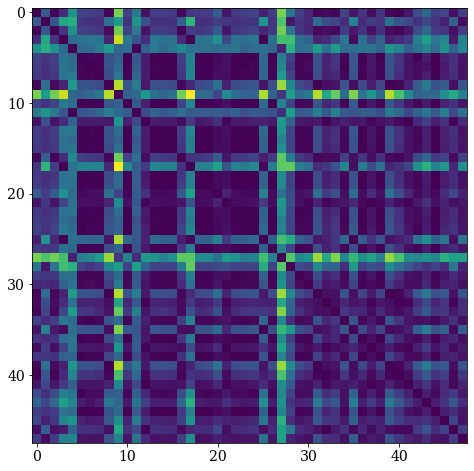

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(Dc)
plt.show()